# [Lightkurve](https://docs.lightkurve.org/)

## Table of Contents
- [Overview](#overview)
- [A Quick Introduction](#a-hands-on-introduction)

# Overview
Lightkurve is a user-friendly Python package that is designed to make interacting with [TESS](https://science.nasa.gov/mission/tess/) and [Kepler](https://science.nasa.gov/mission/kepler/) time-series photometry easy and accessible. It is well documented, and there are pre-existing [tutorials](https://docs.lightkurve.org/tutorials/index.html) that covers most functionality. This lesson will go over the primary use-cases, best practices, and examples, as well as some exercises to practice and improve understanding. 

# A Hands-On Introduction
There are three primary objects used in `Lighkurve`:
* `LightCurve` object
* `TargetPixelFile` objects
* `Periodogram` objects

Before diving into the details of these objects, this first section will give a quickstart by getting you downloading, plotting, and visualizing an exoplanet transit. 

First, we import `lightkurve`:

In [2]:
import lightkurve as lk
from matplotlib import pyplot as plt
import numpy as np

The first step is to download the `target pixel file`, which are the 2D images used to construct the timeseries photometry. Let's investigate the known exoplanet system **WASP-121**:

In [3]:
## Downloads all pixel files for the target
pixelfile = lk.search_targetpixelfile("WASP-121").download_all()

ConnectTimeout: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Max retries exceeded with url: /portal/Mashup/Mashup.asmx/columnsconfig (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7fa40830a0f0>, 'Connection to mast.stsci.edu timed out. (connect timeout=None)'))

Let's check out the first image.

<class 'lightkurve.targetpixelfile.TessTargetPixelFile'>


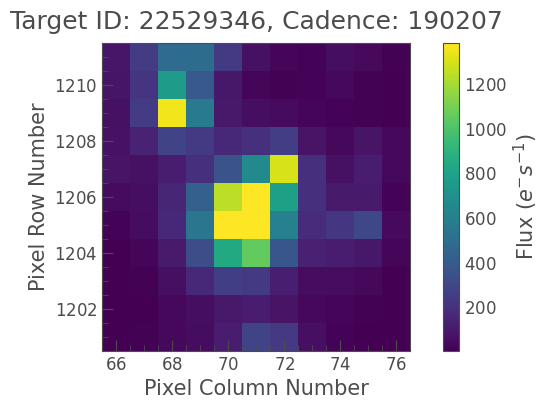

In [6]:
##Check out different images by changing the index!
pixelfile[0].plot()

##We can check the type to see which mission it's derived from (TESS or Kepler)
print(type(pixelfile[0]))

To see the light curve from this data, we use `pixelfile.to_lightcurve`:

In [7]:
##Select a target pixel to analyze, which contains one sector of timeseries data
lc = pixelfile[3].to_lightcurve(aperture_mask='all')

##Plot the results!
lc.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

We can see repeated, deep transit signal here, but what if we want a better view? We can easily access different parts of the light curve by normal Python splicing:

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

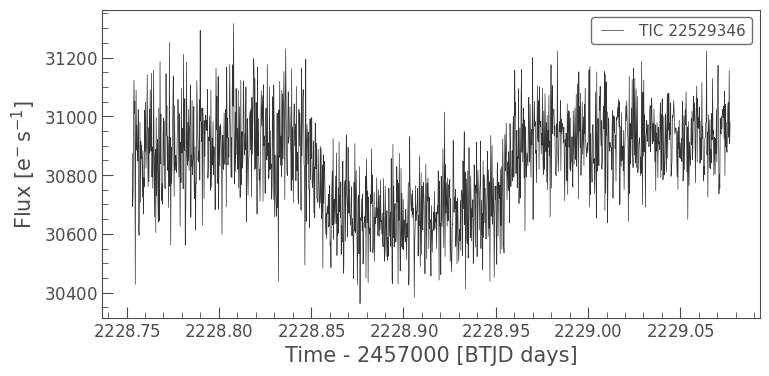

In [50]:
lc[0:1400].plot()

Congrats, you found `WASP-121 b` in real TESS data! The next sections will go more in-depth into the different functions of the three objects in the `lightcurve` module, and will finish with standard work flows that accomplish specific tasks i.e. light-curve detrending.

# [`Lightkurve` Objects](https://docs.lightkurve.org/reference/index.html)
The following will briefly highlight the primary properties and functions of the three `Lightcurve` objects.

## [The LightCurve Object](https://docs.lightkurve.org/reference/lightcurve.html)
This is the object we constructed above. The `Lightcurve` object requires, at a minimum, three parameters:
- Time (`time`)
- Flux (`flux`)
- Flux Error (`flux_err`)

### Construction
`LightCurves` can be constructed like above using `targetpixelfile` objects, or by passing three array-like objects to the `time`, `flux` and `flux_err` parameters. We can retrieve these arrays by passing `LightCurve.time/flux/flux_err`. Using the example above:

In [124]:
#Retrieve the data columns
print(lc.time, lc.flux, lc.flux_err)

#Retrieve metadata
print(lc.meta)

[2228.75309684 2228.75332832 2228.7535598  ... 2254.06842987 2254.06866134
 2254.06889282] [30873.088 30692.766 30750.527 ... 30551.371 30616.508 30738.994] electron / s [86.92682  86.82539  86.83288  ... 50.719883 51.18822  50.73446 ] electron / s
{'APERTURE_MASK': 'all', 'TARGETID': 22529346, 'LABEL': 'TIC 22529346', 'SECTOR': 34, 'CAMERA': 3, 'CCD': 2, 'MISSION': 'TESS', 'RA': 107.600252516386, 'DEC': -39.0973807094915}


### Visualization
`Lightkurve` offers four different routines for plotting. Since these routines are made using `matplotlib`, we can manipulate any plot with `matplotlib` methods. We can examine them below:

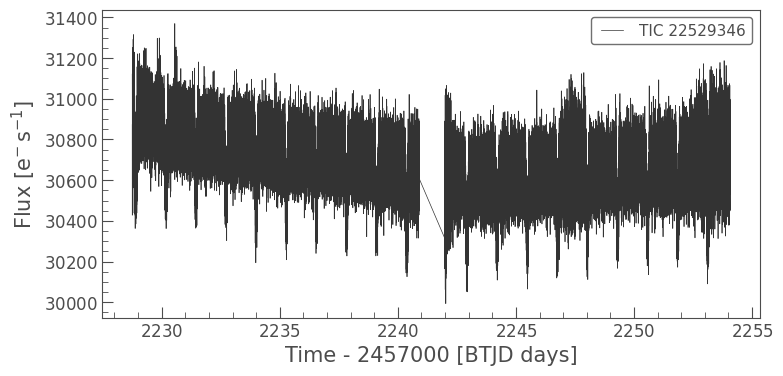

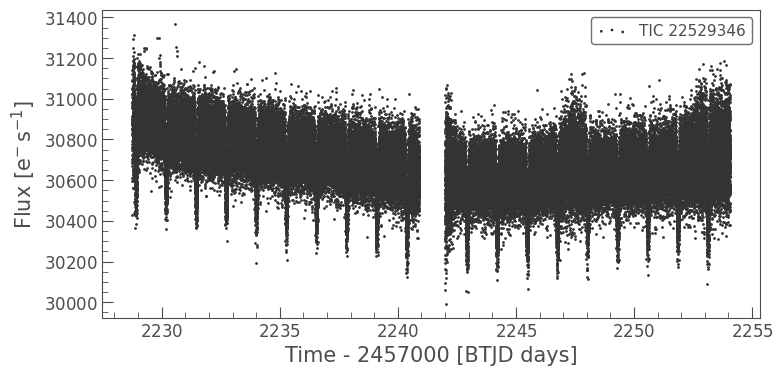

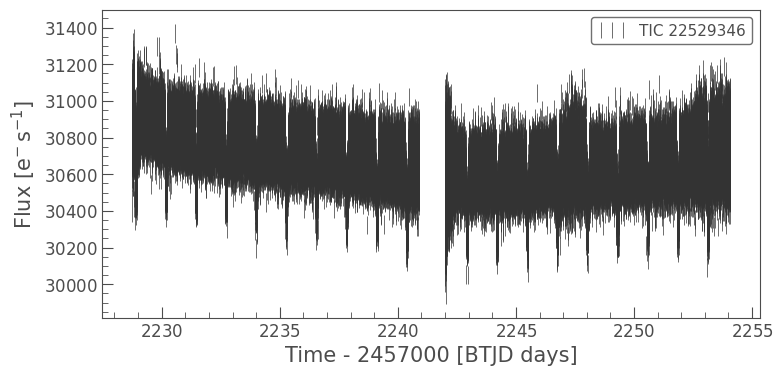

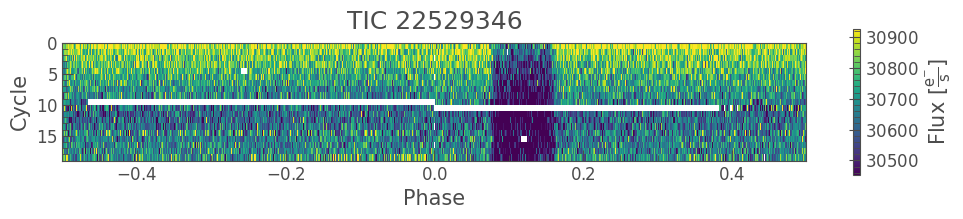

In [78]:
#Standard plot with linear interpolation
lc.plot()
plt.show()
input('Press any key to continue to the scatter plot')
lc.scatter()
plt.show()
input('Press any key to continue to the errobar plot')
lc.errorbar()
plt.show()
input('Press any key to continue to the river plot')

## River plots phase folds the light curve on a set period. For exoplanets, it essentially takes
## each transit and plots it on top of each other, which helps the SNR of the signal,
## Here, the transit manifest itself as a continuous dark band across the data at ~0.1 phase
lc.plot_river(period=1.2749255)
plt.show()

### Data Mainpulation
In order to conduct research, we can apply a variety of useful methods on the light curve in order to clean and reconstruct the lightcurves into something more useful.

#### Detrending/Flattening
The lightcurves above are not perfectly flat, which can be due to systematic effects, variability of the hosts, or stellar rotation modulation due to star spots. To mitiage this, we can use `LightCurve.flatten`, which applies a [Savitzky-Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to remove these trends without effecting the short-term variation.

<div class="alert alert-block alert-info">
 
**IMPORTANT**: When detrending/flattening, the `window_lenth` parameter should be adjusted based on the time-scale of the underlying baseline variation. For example, the light-curves above seem to vary over the entire course of the observations. Thus, the window length should be well within the thousands of data points (~days).

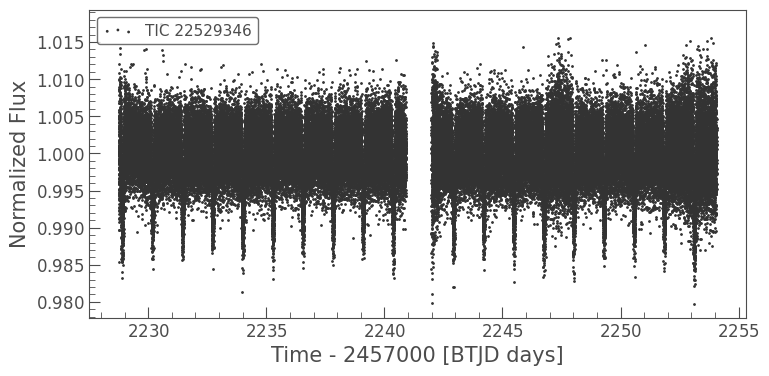

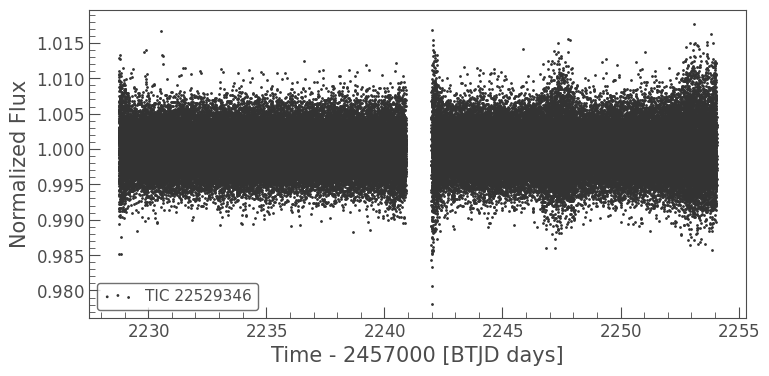

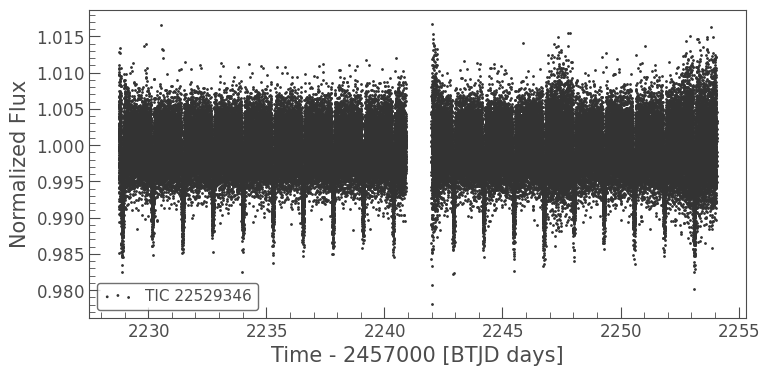

In [118]:
##We need to change the default window_length here, which is 101 data points. This is too short a 
##timescale for our data, which varies over thousands of data points. Otherwise, we will detrend the
## the transits.
lc2 = lc.flatten(window_length=10001)
lc2.scatter()
plt.show()


##An example of bad flattening, even by using the defaults. We've lost our transits!
##Be wary of this. Check the original data to ensure you do not lose important signal, or use a mask, detailed below
lc3 = lc.flatten()
lc3.scatter()
plt.show()

## We can ignore transits using the 'create_transit_mask()' function, too. But this requires knowing the transit period, duration, and midpoint epoch
## These might be parameters you are trying to constrain!
tmask = lc.create_transit_mask(period = 1.27492550, duration = 0.120291667, transit_time = 2228.9)
lc10 = lc.flatten(window_length=101, mask=tmask)
lc10.scatter()
plt.show()

This flattened fairly well, while maintaining the depths of the transits. If there are shorter-frequency signals, you can also use the `mask` parameter in the flatten routine to make the routine ignore certain data points. The mask must be an Boolean array, where `True` data will not be considered in the detrending. This can be used to safely preserve the transits.

#### Clean-up Routines
We can use the `LightCurve.remove_nans` and `LightCurve.remove_outliers` routines to get rid of invalid or spurious data points. 

NOTE: `LightCurve.flatten` will automatically remove outliers, which can be adjusted using the `sigma` parameter. Additionally, it automatically normalizes the light curve, which has its own routine `LightCurve.noramlize()`.

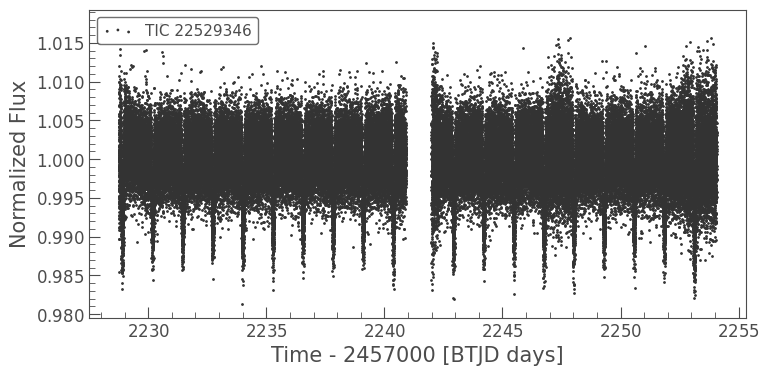

In [52]:
#Remove nans in-place, no need to redefine the variable
lc2 = lc2.remove_nans()
#Clip any spurious data points
lc2 = lc2.remove_outliers(sigma = 5)
lc2.scatter()
plt.show()

#### Phase-Folding and Binning
To get a better constraint on the shape of the transit, we can phase-fold and bin (essentially multi-point averages).

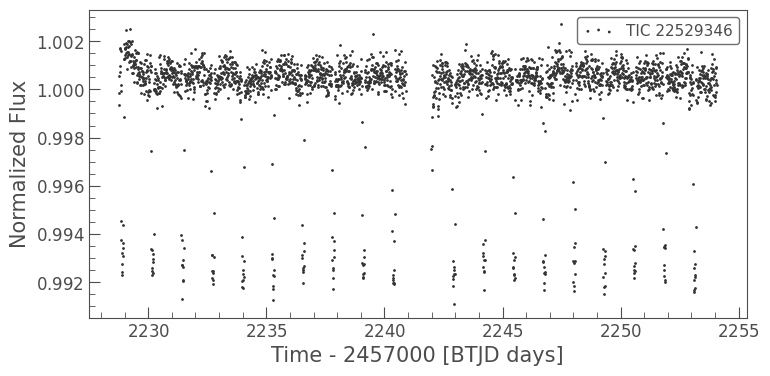

/home/nwhitsett/miniconda3/envs/exocore/lib/python3.12/site-packages/lightkurve/lightcurve.py:1043: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


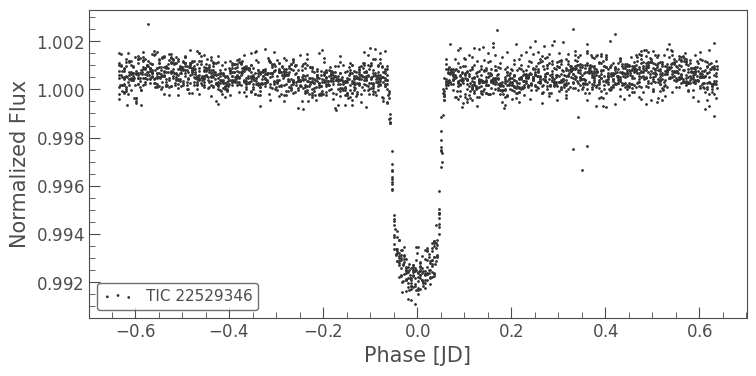

In [128]:
#The binning unit is assumed to be days. This bins every ~7 data points
lc2 = lc2.bin(time_bin_size=0.01)
lc2.scatter()
plt.show()

## We phase fold it based on the known epoch transit time, and set the mid transit phase to 0
lc2 = lc2.fold(period = 1.2749255, epoch_time=2456635.16, epoch_phase=0)
lc2.scatter()
plt.show()


This is a significant improvement! We can append more than one TESS sector by using the `LightCurve.append` methods, and repeating the analysis as before:

/home/nwhitsett/miniconda3/envs/exocore/lib/python3.12/site-packages/lightkurve/lightcurve.py:1043: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


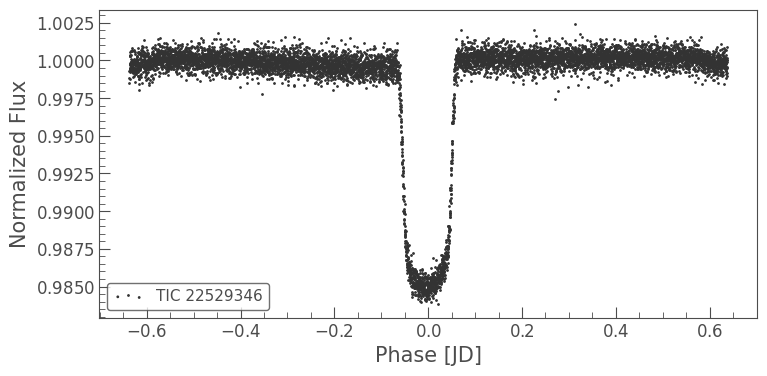

In [111]:
## We can add more and more pixel files to the same light curve object. 
## These pixel files are not as long as the example above, so we use a smaller window_length
lc4 = (pixelfile[9].to_lightcurve()).flatten(window_length = 2001)
lc5 = (pixelfile[8].to_lightcurve()).flatten(window_length = 2001)
lc6 = (pixelfile[7].to_lightcurve()).flatten(window_length = 2001)
#...
lc7 = lc4.append(lc5)
lc7 = lc7.append(lc6)
#...
lc7 = lc7.bin()
## Use the same phase folding parameters as before
lc7 = lc7.fold(period = 1.2749255, epoch_time=2456635.16, epoch_phase=0)
lc7.scatter()

plt.show()

### Export Methods
Lightcurves can be exported to a variety of different file types or other Python structures. These are outlined below:

In [ ]:
##
#Send your lightcurve to a csv file
lc.to_csv("Enter Path Here")

#To an Excel file
lc.to_excel("Enter Path Here")

#To a fits file
lc.to_fits("Enter Path Here")

#To a pandas dataframe
lc.to_pandas("Enter Path Here")

#To a Astropy table
lc.to_table("Enter Path Here")

## [Target Pixel File Object](https://docs.lightkurve.org/reference/targetpixelfile.html)

The "raw" output of TESS and Kepler are target pixel files, which, as mentioned previously, are strung together to create time-series photometry. Normally, these are given as [.fits](https://fits.gsfc.nasa.gov/fits_primer.html) files, which is a standard, multi-dimensional data-type that typically consists of header(s) units (i.e. metadata) and data units (i.e. time, flux). `Lightkurve` automatically downloads and extracts the relevant data from these `.fits` files in easy-to-read Python syntax. To see how to query your favorite systems and their corresponding data, check out the [tutorial](https://docs.lightkurve.org/tutorials/1-getting-started/searching-for-data-products.html).

This section goes over the basic methods of the `TargetPixelFile` object, and best practices. This example covers Kepler target pixel files, but similar syntax also works for TESS.

In [131]:
tpf = lk.search_targetpixelfile('KIC 6922244', author="Kepler", quarter=4, cadence="long").download()
#Get mission data using the .meta property
print(tpf.meta())

#Get the TPF dimensions
#This TPF has a dimensionality of 4116x5x5; that is, 4116, 5x5 images over time.
#If constructed to a light curve, it would yield 4116 data points
print(tpf.flux.shape)

#The resulting first image of the TPF
tpf.plot(frame=0)

#We can get more metadata by using the .get_header property, too
tpf.get_header()[0:10]

#And constructing the lightcurve
kepler_lc = tpf[0].to_lightcurve(aperture_mask='all')

#We can animate the TPFs, too!
tpf.animate(1, 1)

ConnectTimeout: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Max retries exceeded with url: /portal/Mashup/Mashup.asmx/columnsconfig (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7fa3461dd400>, 'Connection to mast.stsci.edu timed out. (connect timeout=None)'))

As we saw in the [introduction](#a-hands-on-introduction), we can use these TPFs to construct custom light curves. You can see the rest of the related functions [here](https://docs.lightkurve.org/reference/targetpixelfile.html).

## `Periodogram` Objects

The last object in the `Lightkurve` module are periodograms, which are typically [Lomb-Scargle Periodograms](https://docs.astropy.org/en/stable/timeseries/lombscargle.html). You can think of this as a discrete Fast-Fourier Transform, but it works for unevenly sampled data. The periodogram allows for the identification of periodic signals in light curves, which can have several sources: transits, eclipsing binaries, stellar modulation, and systemtatics, to name a few. Here, we give a brief example, and how it can be used to constrain the period of a transitting exoplanet.

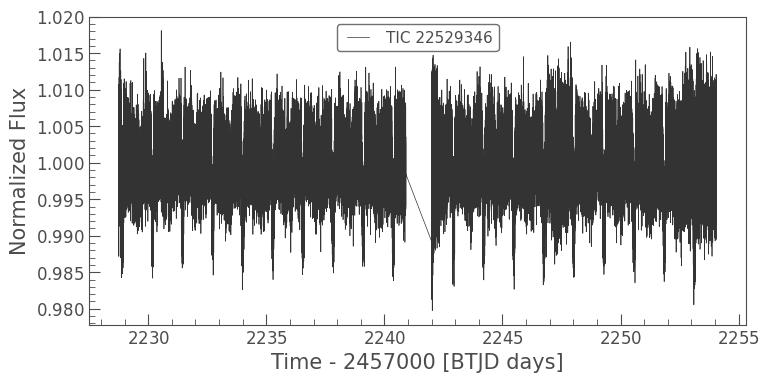

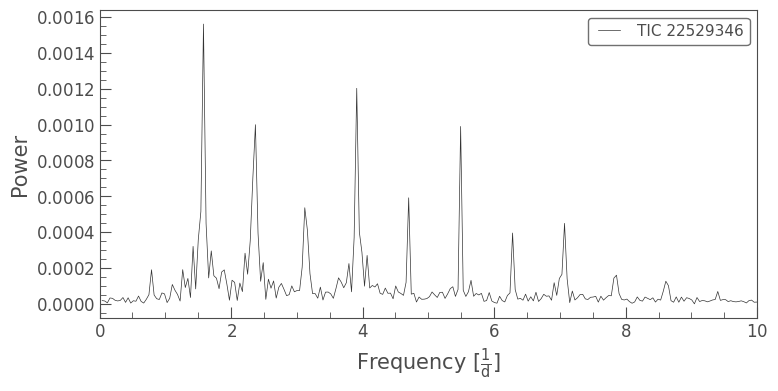

In [139]:
## Begin with our initial light curve
lc = lc.flatten(window_length=5001)
lc.plot()
plt.show()

periodogram = lc.to_periodogram(oversample_factor=1)
periodogram.plot()
plt.xlim(0, 10)
plt.show()

There are many peaks here! To get a better sense, we can plot in terms of period instead of frequency.

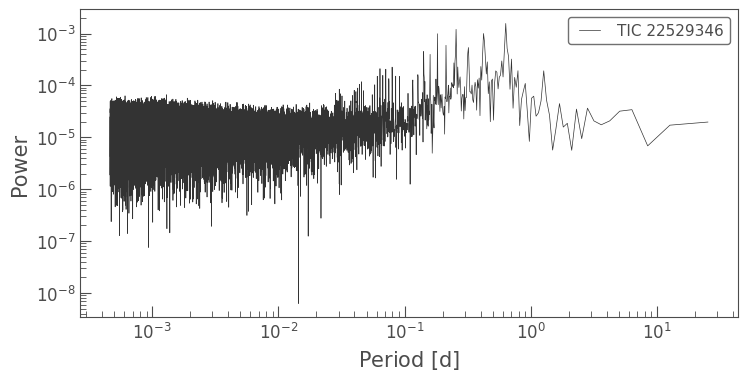

0.6328948995473297 d


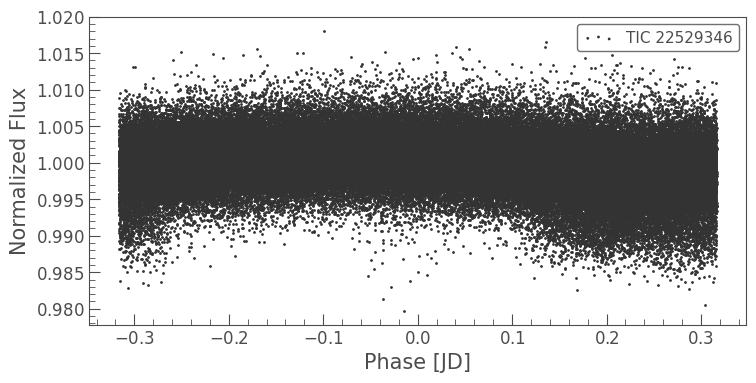

In [149]:
periodogram.plot(view='period', scale='log')
plt.show()

#Find the period with max power
print(periodogram.period_at_max_power)

lc.fold(period=periodogram.period_at_max_power).scatter()

plt.show()

But wait, that phase folded light curve doesn't look right! And in fact, that is not the period of WASP121 b at all, what gives? Well, the other peaks with high power in the periodogram are *harmonics*. Careful observation shows that the max power period above is really the $\frac{period}{2}$. Trying this and we get:

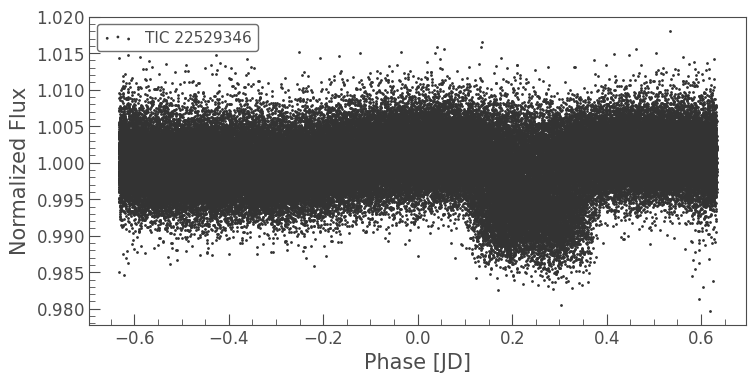

In [152]:
lc.fold(period=periodogram.period_at_max_power*2).scatter()
plt.show()

Better, but not great... This leads to an important note when using periodograms:

<div class="alert alert-block alert-info">
 
**IMPORTANT**: Periodograms are discretely binned. The precision of the extracted period are dependent on how fine the binning is. This can be improved by increasing the `over_sample_factor`. Do note that the higher this factor, the more computationally intensive it will be. 

In [1]:
periodogram = lc.to_periodogram(oversample_factor=1000)
lc.fold(period=periodogram.period_at_max_power*2).scatter()
plt.show()

NameError: name 'lc' is not defined

A significant improvement! We can then use this to derive the **period** and the **duration** to construct 